<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/angelo_albumentations/STEP_3B_PIDNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [61]:
!pip install torchmetrics
!pip install fvcore

In [62]:
from google.colab import drive
import os

!git clone -b vito --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

fatal: destination path 'AML_2025_project4' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [67]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Skipping extraction for the dataset, already extracted.
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [68]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

RESIZE = 512

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 5

GAMMA = 0.1

LR = 0.01

P = 0.5 # probabilità augmentation

# Define and instantiate

### Define PIDnet

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

### Instantiate model

In [71]:
import gdown
#import requests
#import tarfile

#if (os.path.exists("./pidnet.py") == False):
#  url = "https://raw.githubusercontent.com/XuJiacong/PIDNet/refs/heads/main/models/pidnet.py"
#  output_file = "./pidnet.py"
#  response = requests.get(url)
#  response.raise_for_status()
#  with open(output_file, "w", encoding="utf-8") as f:
#    f.write(response.text)
#
#  print("Pidnet model downloaded")
#
#if (os.path.exists("./model_utils.py") == False):
#  url = "https://raw.githubusercontent.com/XuJiacong/PIDNet/refs/heads/main/models/model_utils.py"
#  output_file = "./model_utils.py"
#  response = requests.get(url)
#  response.raise_for_status()
#  with open(output_file, "w", encoding="utf-8") as f:
#    f.write(response.text)
#
#  print("Pidnet utils downloaded")


if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)

  print("imagenet-pretrained pidnet weights downloaded")


class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
next(model.parameters()).device


device(type='cpu')

# Dataset & dataloader

## Dataset definition

In [72]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, augmentation=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.augmentation = augmentation

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])


        # Read an image with OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)


        if self.augmentation:
          transformed = self.augmentation(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]


        mask_np = np.array(mask)

        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        #return image, mask, boundaries_tensor  # Return (image, mask) pair
        return image, mask, boundaries_tensor  # Return (image, mask) pair

## Define transformations
(using albumentations)

In [81]:
# Define transformations for images & masks
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2 as T
import cv2
import itertools


resize_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE, p=1),
    A.ToFloat(),
    ToTensorV2()
])

alb_aug0 = A.HorizontalFlip(p=P)
alb_aug1 = A.GaussianBlur(p=P, sigma_limit=(0.5, 3.0))
alb_aug2 = A.ElasticTransform(alpha=300, sigma=8, p=P)
alb_aug3 = A.HueSaturationValue(
    hue_shift_limit=20,
    sat_shift_limit=30,
    val_shift_limit=20,
    p=P
)

base_augmentations = [alb_aug0,
                  alb_aug1,
                  alb_aug2,
                  alb_aug3]

augmentations = []

for r in range(1, len(base_augmentations) + 1):
    for combo in itertools.combinations(base_augmentations, r):
        augmentation = A.Compose(list(combo))
        augmentations.append(augmentation)


## Dataset instantiation

In [82]:
# Create dataset objects
DOMAIN_SHIFT = True

train_datasets = []

for i, augmentation in enumerate(augmentations):

  train_dataset = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                      transform=resize_transform, augmentation=augmentation)
  train_datasets.append(train_dataset)

if not DOMAIN_SHIFT:
  val_dataset = SegmentationDataset(VAL_PATH_URBAN + "/images_png", VAL_PATH_URBAN + "/masks_png",
                                    transform=resize_transform)
else:
  val_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=resize_transform)

## Loader instantiation

In [83]:
# Create DataLoaders
train_loaders = []

for dataset in train_datasets:
  train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  train_loaders.append(train_loader)


train_loader = train_loaders[2] # provo con dataloader modifica saturation hue
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.float32
tensor([0, 1, 2])
tensor([0., 1.])
torch.float32
tensor([0, 1, 2, 4])
tensor([0., 1.])
torch.float32
tensor([-1,  0,  1,  2,  5])
tensor([0., 1.])


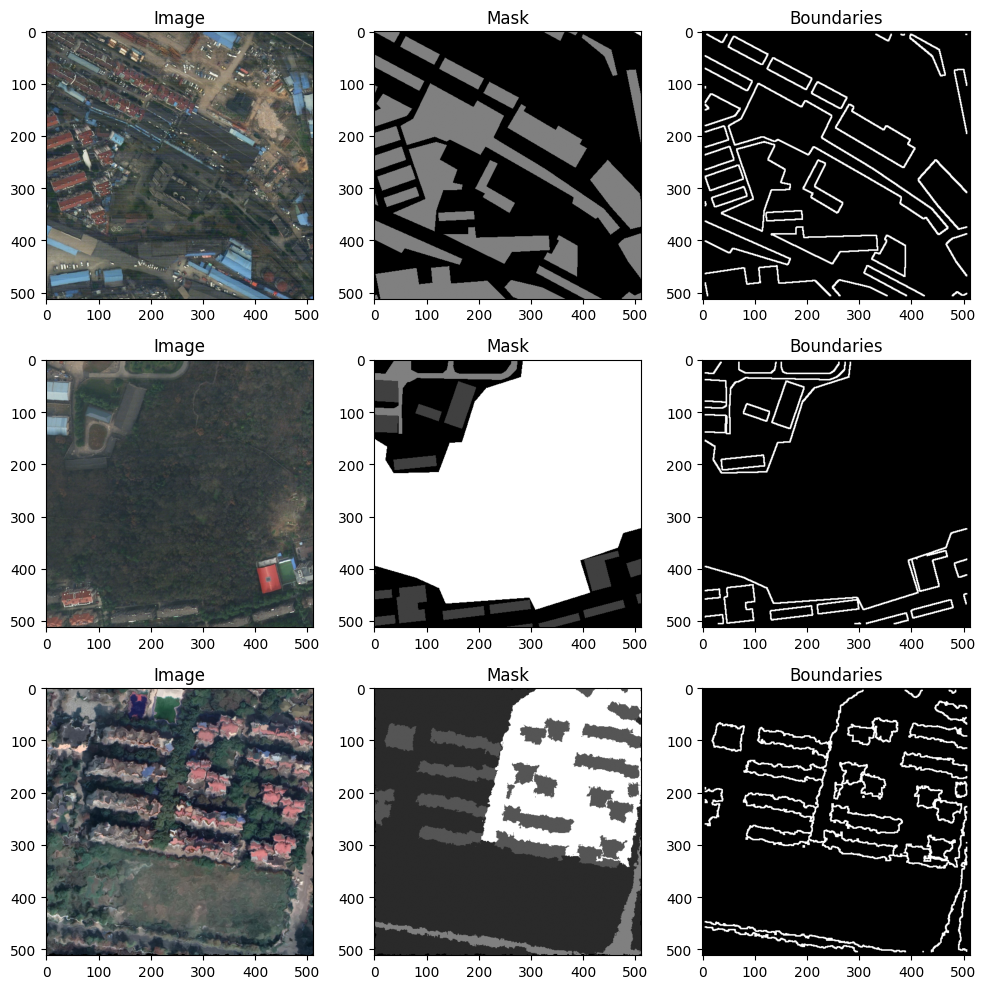

In [84]:
from utils import show
from matplotlib import pyplot as plt

batch = next(iter(train_loader))  # (images, masks, boundaries)
images, masks, boundaries = batch  # Unpack the batch

fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3 images, each with RGB, mask, and boundary

for i in range(3):  # Show first 3 images
    print(images[i].dtype)

    # Permute the dimensions of the image tensor to (height, width, channels)
    image_np = images[i].cpu().numpy().transpose(1, 2, 0)

    axes[i, 0].imshow(image_np) # Display the image with the correct shape
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(masks[i].cpu().numpy(), cmap="gray")  # Show mask
    axes[i, 1].set_title("Mask")

    axes[i, 2].imshow(boundaries[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 2].set_title("Boundaries")


    print(torch.unique(masks[i]))
    print(torch.unique(boundaries[i]))

plt.tight_layout()
plt.show()

# Training Phase

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print(device);

cuda


In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Extra Semantic Loss (Classica CrossEntropy Loss)
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target):
        return self.loss(pred, target)

# 2. Weighted Binary Cross Entropy per i bordi
class WeightedBinaryCrossEntropy(nn.Module):
    def __init__(self, pos_weight=20.0):  # Peso λ1 sui bordi
        super(WeightedBinaryCrossEntropy, self).__init__()
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))

    def forward(self, pred, target):
        return self.loss(pred, target)

# 3. Boundary-Aware CrossEntropy Loss
class BoundaryAwareCELoss(nn.Module):
    def __init__(self, weight=None):
        super(BoundaryAwareCELoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target, boundary_mask):
        ce_loss = self.loss(pred, target)
        return torch.mean(ce_loss * boundary_mask)  # Pesa i bordi

# 4. BAS-Loss per segmentazione e detection dei bordi
class BASLoss(nn.Module):
    def __init__(self, threshold=0.8):
        super(BASLoss, self).__init__()
        self.threshold = threshold

    def forward(self, boundary_head, pred, target):
        boundary_mask = (boundary_head > self.threshold).float()  # Maschera bordi
        log_probs = F.log_softmax(pred, dim=1)

        # Reshape per compatibilità
        batch_size, num_classes, H, W = log_probs.shape
        log_probs = log_probs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # [B*H*W, num_classes]
        target = target.reshape(-1)  # [B*H*W]
        boundary_mask = boundary_mask.reshape(-1)  # [B*H*W]

        # Applica la perdita solo ai bordi
        loss = -torch.sum(boundary_mask * log_probs[torch.arange(target.shape[0]), target])

        # Normalizza rispetto al numero di pixel nei bordi (evita divisioni per 0)
        return loss / (boundary_mask.sum() + 1e-6)

# 5. PIDNet Loss Totale
class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8):
        super(PIDNetLoss, self).__init__()
        self.ce_loss = CrossEntropyLoss()
        self.wbce_loss = WeightedBinaryCrossEntropy(pos_weight=lambda_1)
        self.boundary_ce_loss = BoundaryAwareCELoss()
        self.bas_loss = BASLoss(threshold)

        self.lambda_0 = lambda_0
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3

    def forward(self, pred, target, boundary_head, boundary_mask):
        """
        pred: output principale (B, C, H, W)
        target: ground truth segmentazione (B, H, W)
        boundary_head: predizione dei bordi (B, 1, H, W)
        boundary_mask: ground truth dei bordi (B, 1, H, W)
        """
        L0 = self.ce_loss(pred, target)  # Extra Semantic Loss
        L1 = self.wbce_loss(boundary_head, boundary_mask.unsqueeze(1))  # Weighted BCE
        L2 = self.boundary_ce_loss(pred, target, boundary_mask)  # Boundary-Aware CE
        L3 = self.bas_loss(boundary_head, pred, target)  # BAS-Loss

        loss = (self.lambda_0 * L0 +
                self.lambda_1 * L1 +
                self.lambda_2 * L2 +
                self.lambda_3 * L3)

        return loss


In [87]:
"""
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target):
        return self.loss(pred, target)

class BoundaryAwareCELoss(nn.Module):
    def __init__(self, weight=None):
        super(BoundaryAwareCELoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target, boundary_mask):
        loss = self.loss(pred, target)
        return torch.mean(loss * boundary_mask)  # Penalizza maggiormente i bordi

class BASLoss(nn.Module):
    def __init__(self, threshold=0.8):
        super(BASLoss, self).__init__()
        self.threshold = threshold

    def forward(self, boundary_head, pred, target):
        boundary_mask = (boundary_head > self.threshold).float()  # Maschera dei bordi
        log_probs = F.log_softmax(pred, dim=1)  # Calcola log-softmax

        # Appiattisci tutto per evitare errori di broadcasting
        batch_size, num_classes, H, W = log_probs.shape
        log_probs = log_probs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # [B*H*W, num_classes]
        target = target.reshape(-1)  # [B*H*W]
        boundary_mask = boundary_mask.reshape(-1)  # [B*H*W]

        # Ora target ha shape [B*H*W] e log_probs ha [B*H*W, num_classes]
        loss = -torch.sum(boundary_mask * log_probs[torch.arange(target.shape[0]), target])

        return loss / (boundary_mask.sum() + 1e-6)  # Evita divisioni per zero


class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8):
        super(PIDNetLoss, self).__init__()
        self.ce_loss = CrossEntropyLoss()
        self.boundary_ce_loss = BoundaryAwareCELoss()
        self.bas_loss = BASLoss(threshold)

        self.lambda_0 = lambda_0
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3

    def forward(self, pred, target, boundary_head, boundary_mask):
        L0 = self.ce_loss(pred, target)
        L1 = self.ce_loss(pred, target)  # Stessa loss con pesi diversi
        L2 = self.boundary_ce_loss(pred, target, boundary_mask)
        L3 = self.bas_loss(boundary_head, pred, target)

        loss = (self.lambda_0 * L0 +
                self.lambda_1 * L1 +
                self.lambda_2 * L2 +
                self.lambda_3 * L3)

        return loss
"""

'\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass CrossEntropyLoss(nn.Module):\n    def __init__(self, weight=None):\n        super(CrossEntropyLoss, self).__init__()\n        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)\n\n    def forward(self, pred, target):\n        return self.loss(pred, target)\n\nclass BoundaryAwareCELoss(nn.Module):\n    def __init__(self, weight=None):\n        super(BoundaryAwareCELoss, self).__init__()\n        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)\n\n    def forward(self, pred, target, boundary_mask):\n        loss = self.loss(pred, target)\n        return torch.mean(loss * boundary_mask)  # Penalizza maggiormente i bordi\n\nclass BASLoss(nn.Module):\n    def __init__(self, threshold=0.8):\n        super(BASLoss, self).__init__()\n        self.threshold = threshold\n\n    def forward(self, boundary_head, pred, target):\n        boundary_mask = (boundary_head > self.threshold).float()

In [88]:
batch = next(iter(train_loader))  # (images, masks, boundaries)
X, y, boundaries = batch  # Unpack the batch
X = X.to(device)
y = y.to(device)

print("X =", X.shape)
print("y =", y.shape)
print("boundary =", boundaries.shape)
print(X.dtype)

# Output del modello
outputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

# Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
# Quindi passiamo da 64 x 64 a 512 x 512
h, w = boundaries.size(1), boundaries.size(2)
ph, pw = outputs[0].size(2), outputs[0].size(3)
if ph != h or pw != w:
    for i in range(len(outputs)):
        outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

pred_p, pred_main, boundary_head = outputs  # P, I, D branches

#print("outputs[0] =", outputs[0].shape) # pred_p
print("outputs[1] =", outputs[1].shape) # pred_main
print("outputs[2] =", outputs[2].shape) # Ramo D (boundary_head)

preds = torch.argmax(pred_main, dim=1)
print("preds =", preds.shape)


X = torch.Size([16, 3, 512, 512])
y = torch.Size([16, 512, 512])
boundary = torch.Size([16, 512, 512])
torch.float32
outputs[1] = torch.Size([16, 7, 512, 512])
outputs[2] = torch.Size([16, 1, 512, 512])
preds = torch.Size([16, 512, 512])


In [89]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

os.makedirs("/content/drive/MyDrive/AML_project/checkpoints", exist_ok=True)

torch.manual_seed(SEED)

num_classes = 7  # Cambia in base al tuo dataset
#miou_classes = MeanIoU(num_classes=num_classes, per_class=True).to(device)
#miou_overall = MeanIoU(num_classes=num_classes).to(device)
loss_fn = PIDNetLoss()

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    total_train_samples = 0

    batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}", ncols=100)

    for batch, (X, y, boundary_mask) in batch_pbar:
        X = X.to(device)
        y = y.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

        # Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
        # Quindi passiamo da 64 x 64 della rete a 512 x 512
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs  # P, I, D branches
        else:
            pred_main = outputs
            boundary_head = None  # Nessuna branch D se augment=False

        # Calcolo della loss
        loss = loss_fn(pred_main, y, boundary_head, boundary_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_samples += X.size(0)

        train_loss += loss.item()
        batch_pbar.set_postfix(loss=loss.item())

    #avg_train_loss = train_loss / len(train_loader)

    #total_samples = sum(len(batch[0]) for batch in train_loader)
    avg_train_loss = train_loss / total_train_samples


    print(f"Epoch {epoch+1}/{EPOCHS} - Training Loss: {avg_train_loss}")


    # **Validazione**
    model.eval()
    val_loss = 0

    total_union = torch.zeros(NUM_CLASSES).to(device)
    total_intersection = torch.zeros(NUM_CLASSES).to(device)

    import torch.nn.functional as F

    total_val_samples = 0

    with torch.inference_mode():
        for X_val, y_val, boundary_mask in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            boundary_mask = boundary_mask.to(device)

            # Output del modello
            outputs = model(X_val)

            ## Upscale trough bilinear interpolation
            h, w = boundary_mask.size(1), boundary_mask.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
                for i in range(len(outputs)):
                    outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

            if model.augment:
                pred_p, pred_main, boundary_head = outputs
            else:
                pred_main = outputs
                boundary_head = None

            output_class_per_pixel = torch.argmax(outputs[1], dim=1)

            for predicted, target in zip(output_class_per_pixel, y_val):
              for i in range(NUM_CLASSES):
                total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))


            # Calcola la loss
            loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

            val_loss += loss.item()

            total_val_samples += X_val.size(0)

    avg_val_loss = val_loss / total_val_samples


    intersection_over_union = total_intersection / total_union
    # per class
    for i, iou in enumerate(intersection_over_union):
        class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
        print(f'{class_name} IoU: {iou:.4f}')

    miou = torch.mean(intersection_over_union)
    print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou}")

    if epoch % 5 == 0:
      print(scheduler.get_last_lr())


    ## steps the scheduler
    scheduler.step()


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=46.6]

Epoch 1/20 - Training Loss: 2.5146560355453755


background IoU: 0.3633
building IoU: 0.1396
road IoU: 0.0249
water IoU: 0.0306
barren IoU: 0.0227
forest IoU: 0.0531
agriculture IoU: 0.0079
Epoch 1/20 - Validation Loss: 1.8026146311913767 - mIoU: 0.09175710380077362
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=34.5]

Epoch 2/20 - Training Loss: 2.08788118725417


background IoU: 0.4485
building IoU: 0.3082
road IoU: 0.0727
water IoU: 0.0843
barren IoU: 0.0338
forest IoU: 0.0405
agriculture IoU: 0.0005
Epoch 2/20 - Validation Loss: 1.6503023197574 - mIoU: 0.1412118673324585


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=33.6]

Epoch 3/20 - Training Loss: 2.029767064487233


background IoU: 0.4404
building IoU: 0.2518
road IoU: 0.0996
water IoU: 0.1420
barren IoU: 0.0362
forest IoU: 0.0351
agriculture IoU: 0.0020
Epoch 3/20 - Validation Loss: 1.596996243922941 - mIoU: 0.14386528730392456


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:30<00:00,  2.37it/s, loss=42.4]

Epoch 4/20 - Training Loss: 2.013214853808129


background IoU: 0.4402
building IoU: 0.2954
road IoU: 0.1192
water IoU: 0.1742
barren IoU: 0.0414
forest IoU: 0.0214
agriculture IoU: 0.0025
Epoch 4/20 - Validation Loss: 1.7076111455117502 - mIoU: 0.1563226878643036


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=33.1]

Epoch 5/20 - Training Loss: 1.983823010665735


background IoU: 0.4081
building IoU: 0.3270
road IoU: 0.1586
water IoU: 0.1874
barren IoU: 0.0307
forest IoU: 0.0407
agriculture IoU: 0.0162
Epoch 5/20 - Validation Loss: 1.5949915820552456 - mIoU: 0.16695769131183624


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=35.9]

Epoch 6/20 - Training Loss: 1.973608883194445


background IoU: 0.4558
building IoU: 0.3237
road IoU: 0.1715
water IoU: 0.1696
barren IoU: 0.0410
forest IoU: 0.0445
agriculture IoU: 0.0143
Epoch 6/20 - Validation Loss: 1.548444761383918 - mIoU: 0.17433753609657288
[0.001]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=28.4]

Epoch 7/20 - Training Loss: 1.9596142042879414


background IoU: 0.4606
building IoU: 0.3067
road IoU: 0.1571
water IoU: 0.1731
barren IoU: 0.0421
forest IoU: 0.0360
agriculture IoU: 0.0136
Epoch 7/20 - Validation Loss: 1.5479022918208953 - mIoU: 0.16987743973731995


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:30<00:00,  2.38it/s, loss=28.8]

Epoch 8/20 - Training Loss: 1.951304028190956


background IoU: 0.4577
building IoU: 0.3229
road IoU: 0.1704
water IoU: 0.1767
barren IoU: 0.0442
forest IoU: 0.0430
agriculture IoU: 0.0165
Epoch 8/20 - Validation Loss: 1.5448329487154562 - mIoU: 0.17590013146400452


Epoch 9/20: 100%|██████████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=46]

Epoch 9/20 - Training Loss: 1.9693197676054746


background IoU: 0.4622
building IoU: 0.3172
road IoU: 0.1575
water IoU: 0.2079
barren IoU: 0.0399
forest IoU: 0.0438
agriculture IoU: 0.0091
Epoch 9/20 - Validation Loss: 1.5495261261540074 - mIoU: 0.17682573199272156


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=38.8]

Epoch 10/20 - Training Loss: 1.956951986134671


background IoU: 0.4674
building IoU: 0.3312
road IoU: 0.1790
water IoU: 0.2094
barren IoU: 0.0457
forest IoU: 0.0499
agriculture IoU: 0.0146
Epoch 10/20 - Validation Loss: 1.5552454398524376 - mIoU: 0.18531566858291626


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=32.8]

Epoch 11/20 - Training Loss: 1.9515220054705662


background IoU: 0.4582
building IoU: 0.3251
road IoU: 0.1805
water IoU: 0.1821
barren IoU: 0.0439
forest IoU: 0.0376
agriculture IoU: 0.0116
Epoch 11/20 - Validation Loss: 1.5421397666777334 - mIoU: 0.17700454592704773
[0.0001]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=35.2]

Epoch 12/20 - Training Loss: 1.9488291492924146


background IoU: 0.4632
building IoU: 0.3168
road IoU: 0.1763
water IoU: 0.1840
barren IoU: 0.0468
forest IoU: 0.0384
agriculture IoU: 0.0160
Epoch 12/20 - Validation Loss: 1.541693918166622 - mIoU: 0.17735643684864044


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.38it/s, loss=36.2]

Epoch 13/20 - Training Loss: 1.9579102044287024


background IoU: 0.4539
building IoU: 0.3247
road IoU: 0.1813
water IoU: 0.1499
barren IoU: 0.0461
forest IoU: 0.0369
agriculture IoU: 0.0151
Epoch 13/20 - Validation Loss: 1.5445497651253977 - mIoU: 0.1725335717201233


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=26.5]

Epoch 14/20 - Training Loss: 1.9460918911600609


background IoU: 0.4527
building IoU: 0.3125
road IoU: 0.1820
water IoU: 0.1749
barren IoU: 0.0435
forest IoU: 0.0385
agriculture IoU: 0.0176
Epoch 14/20 - Validation Loss: 1.5443332656737296 - mIoU: 0.17454153299331665


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=28.5]

Epoch 15/20 - Training Loss: 1.9451764512639558


background IoU: 0.4563
building IoU: 0.3164
road IoU: 0.1742
water IoU: 0.1844
barren IoU: 0.0440
forest IoU: 0.0369
agriculture IoU: 0.0112
Epoch 15/20 - Validation Loss: 1.5440657869462044 - mIoU: 0.1747693419456482


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.37it/s, loss=41.5]

Epoch 16/20 - Training Loss: 1.9528220929076514


background IoU: 0.4638
building IoU: 0.3215
road IoU: 0.1727
water IoU: 0.1962
barren IoU: 0.0438
forest IoU: 0.0455
agriculture IoU: 0.0170
Epoch 16/20 - Validation Loss: 1.5470071608020413 - mIoU: 0.18005487322807312
[1e-05]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=25.9]

Epoch 17/20 - Training Loss: 1.9476590321550733


background IoU: 0.4610
building IoU: 0.3386
road IoU: 0.1788
water IoU: 0.1852
barren IoU: 0.0458
forest IoU: 0.0484
agriculture IoU: 0.0220
Epoch 17/20 - Validation Loss: 1.5436534554727617 - mIoU: 0.18281695246696472


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:31<00:00,  2.34it/s, loss=30.8]

Epoch 18/20 - Training Loss: 1.9465697727401363


background IoU: 0.4645
building IoU: 0.3352
road IoU: 0.1680
water IoU: 0.1860
barren IoU: 0.0454
forest IoU: 0.0403
agriculture IoU: 0.0184
Epoch 18/20 - Validation Loss: 1.5487177679615636 - mIoU: 0.17968016862869263


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=34.8]

Epoch 19/20 - Training Loss: 1.9520001031948209


background IoU: 0.4651
building IoU: 0.3266
road IoU: 0.1630
water IoU: 0.1968
barren IoU: 0.0453
forest IoU: 0.0438
agriculture IoU: 0.0173
Epoch 19/20 - Validation Loss: 1.548434236357289 - mIoU: 0.17970259487628937


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.37it/s, loss=32.9]

Epoch 20/20 - Training Loss: 1.9525767214158003


background IoU: 0.4611
building IoU: 0.3288
road IoU: 0.1723
water IoU: 0.2024
barren IoU: 0.0436
forest IoU: 0.0397
agriculture IoU: 0.0122
Epoch 20/20 - Validation Loss: 1.5417488467308782 - mIoU: 0.1800042688846588


In [90]:
# **Validazione**
model.eval()
val_loss = 0
#miou_classes.reset()
#miou_overall.reset()

total_union = torch.zeros(NUM_CLASSES).to(device)
total_intersection = torch.zeros(NUM_CLASSES).to(device)

import torch.nn.functional as F

total_val_samples = 0

with torch.inference_mode():
    for X_val, y_val, boundary_mask in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        ## Upscale trough bilinear interpolation
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs
        else:
            pred_main = outputs
            boundary_head = None

        output_class_per_pixel = torch.argmax(outputs[1], dim=1)

        for predicted, target in zip(output_class_per_pixel, y_val):
          for i in range(NUM_CLASSES):
            total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
            total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))



        # Calcola la loss
        loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

        val_loss += loss.item()

        total_val_samples += X_val.size(0)

avg_val_loss = val_loss / total_val_samples


intersection_over_union = total_intersection / total_union
# per class
for i, iou in enumerate(intersection_over_union):
    class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
    print(f'{class_name} IoU: {iou:.4f}')

miou = torch.mean(intersection_over_union)


print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou}")


background IoU: 0.4611
building IoU: 0.3288
road IoU: 0.1723
water IoU: 0.2024
barren IoU: 0.0436
forest IoU: 0.0397
agriculture IoU: 0.0122
Epoch 20/20 - Validation Loss: 1.5417488486536088 - mIoU: 0.1800042688846588


In [91]:
pred_main.argmax(dim=1).shape

torch.Size([16, 512, 512])

### Salvataggio del modello su drive

In [92]:
checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_urban.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Modello salvato: {checkpoint_path}")

Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_urban.pth


## Criterions

*********


FLOPs: 6.317 GFLOPs
Average inference latency is 0.016 seconds.


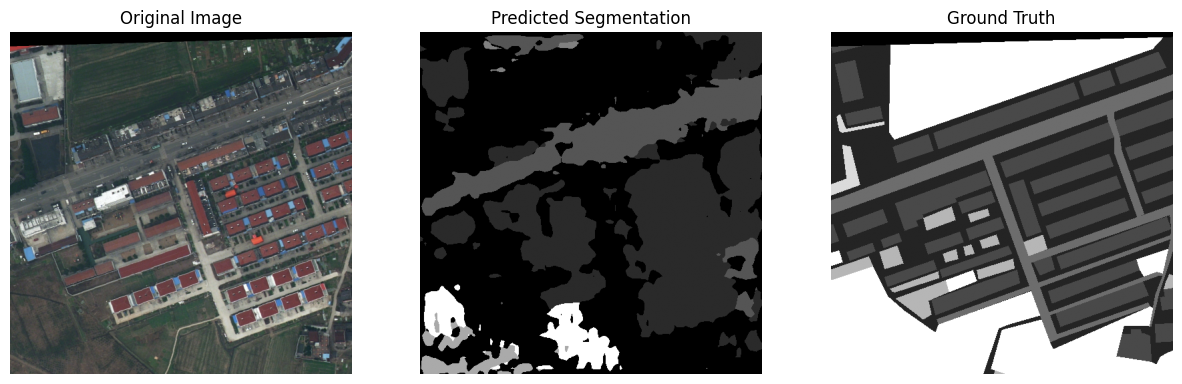

Params: 7.718 M


In [106]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.inference_mode():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(val_dataset) - 1)
    X, y, boundary_mask = val_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    latency = end - start

    ## Upscale trough bilinear interpolation
    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

    # Se augment=True, gestiamo i diversi output
    if model.augment:
        pred_p, pred_main, boundary_head = outputs
    else:
        pred_main = outputs
        boundary_head = None

    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(pred_main, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = pred_main.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
    y_np = y.squeeze().cpu().numpy()  # Ground truth
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")


In [94]:
"""
 # **Validazione**
model.eval()
val_loss = 0
miou.reset()

total_val_samples = 0

with torch.inference_mode():
    for X_val, y_val, boundary_mask in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        ## Upscale trough bilinear interpolation
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs
        else:
            pred_main = outputs
            boundary_head = None

        # Converte le predizioni nei valori di classe più probabili
        preds = torch.argmax(pred_main, dim=1)


        target_one_hot = F.one_hot(y_val+1, num_classes=num_classes+1)

        target_one_hot = target_one_hot[:, :, :, 1:] -1 # Shape: [8, 16, 16, 7]

        # Permute to get (N, C, H, W)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).bool()


        pred_miou = F.one_hot(pred_main.argmax(dim=1), num_classes=num_classes).permute(0, 3, 1, 2).to(torch.bool)  # Shape: [8, 7, 16, 16]
        #avg_miou = pred_main.mean()

        # Converte le predizioni nei valori di classe più probabili
        #preds = torch.argmax(pred_main, dim=1)

        miou.update(preds=pred_miou, target=target_one_hot)

        # Calcola la loss
        loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

        val_loss += loss.item()

        total_val_samples += X_val.size(0)

avg_val_loss = val_loss / total_val_samples

miou_per_class = miou.compute()  # Returns a tensor with per-class IoU
miou_per_class_str = ", ".join([f"Class {i}: {iou:.4f}" for i, iou in enumerate(miou_per_class)])
print(f"Validation Loss: {avg_val_loss} - avg mIoU: {avg_miou} - mIoU per class: {miou_per_class_str}")
"""

'\n # **Validazione**\nmodel.eval()\nval_loss = 0\nmiou.reset()\n\ntotal_val_samples = 0\n\nwith torch.inference_mode():\n    for X_val, y_val, boundary_mask in val_loader:\n        X_val = X_val.to(device)\n        y_val = y_val.to(device)\n        boundary_mask = boundary_mask.to(device)\n\n        # Output del modello\n        outputs = model(X_val)\n\n        ## Upscale trough bilinear interpolation\n        h, w = boundary_mask.size(1), boundary_mask.size(2)\n        ph, pw = outputs[0].size(2), outputs[0].size(3)\n        if ph != h or pw != w:\n            for i in range(len(outputs)):\n                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode=\'bilinear\', align_corners=True)\n\n        if model.augment:\n            pred_p, pred_main, boundary_head = outputs\n        else:\n            pred_main = outputs\n            boundary_head = None\n\n        # Converte le predizioni nei valori di classe più probabili\n        preds = torch.argmax(pred_main, dim=1)\n\n\n 